# Fonctions de base

In [ ]:
import pandas as pd
import gurobipy
from gurobipy import Model, GRB, quicksum
import matplotlib.pyplot as plt

def load_data():
    """Charge les données à partir des fichiers CSV."""
    brick_index_value = pd.read_csv('./bricks_index_values.csv')
    brick_rp_distances = pd.read_csv('./brick_rp_distances.csv')
    bricks = brick_index_value['brick'].tolist()
    reps = list(range(1, 5))  # 4 représentants

    distances = {
        row['brick']: [row[f'rp{i}'] for i in reps]
        for _, row in brick_rp_distances.iterrows()
    }
    
    index_values = dict(zip(brick_index_value['brick'], brick_index_value['index_value']))

    return bricks, reps, distances, index_values

def setup_model_minimize_distance(bricks, reps, distances, index_values, L=0.8, U=1.2):
    """Crée et configure le modèle Gurobi pour minimiser la distance."""
    model = Model("Minimize_Distance")

    # Variables de décision
    x = model.addVars(bricks, reps, vtype=GRB.BINARY, name="x")

    # Fonction objectif : minimiser la distance totale
    model.setObjective(
        quicksum(distances[b][r - 1] * x[b, r] for b in bricks for r in reps), GRB.MINIMIZE
    )

    # Contraintes : chaque brique est assignée à un seul représentant
    model.addConstrs(
        (quicksum(x[b, r] for r in reps) == 1 for b in bricks), name="AssignEachBrick"
    )

    # Contraintes de charge de travail dans l'intervalle [L, U]
    model.addConstrs(
        (quicksum(index_values[b] * x[b, r] for b in bricks) >= L for r in reps), name="MinWorkload"
    )
    model.addConstrs(
        (quicksum(index_values[b] * x[b, r] for b in bricks) <= U for r in reps), name="MaxWorkload"
    )

    return model, x

def setup_model_minimize_disruption(bricks, reps, index_values, initial_assignment, L=0.8, U=1.2):
    """Crée et configure le modèle Gurobi pour minimiser la perturbation."""
    model = Model("Minimize_Disruption")

    # Variables de décision
    x = model.addVars(bricks, reps, vtype=GRB.BINARY, name="x")
    y = model.addVars(bricks, reps, vtype=GRB.BINARY, name="y")

    # Fonction objectif : minimiser la perturbation pondérée par l'index
    model.setObjective(
        quicksum(index_values[b] * y[b, r] for b in bricks for r in reps), GRB.MINIMIZE
    )

    # Contraintes : chaque brick doit être attribué à un seul représentant
    model.addConstrs(
        (quicksum(x[b, r] for r in reps) == 1 for b in bricks), name="AssignEachBrick"
    )

    # Contraintes de charge de travail dans l'intervalle [L, U]
    model.addConstrs(
        (quicksum(index_values[b] * x[b, r] for b in bricks) >= L for r in reps), name="MinWorkload"
    )
    model.addConstrs(
        (quicksum(index_values[b] * x[b, r] for b in bricks) <= U for r in reps), name="MaxWorkload"
    )

    # Mesurer la perturbation
    model.addConstrs(
        (y[b, r] >= x[b, r] - (1 if initial_assignment[b] == r else 0)
         for b in bricks for r in reps), name="Disruption"
    )

    return model, x, y

def solve_model(model):
    """Résout le modèle d'optimisation."""
    model.optimize()

    if model.Status == GRB.OPTIMAL:
        print("\nSolution optimale trouvée :", model.ObjVal)
        return True
    else:
        print("\nLe modèle n'a pas trouvé de solution optimale.")
        return False

def extract_results(bricks, reps, x):
    """Extrait les résultats du modèle et retourne un DataFrame."""
    results = []
    for b in bricks:
        for r in reps:
            if x[b, r].X > 0.5:
                results.append([b, r])

    results_df = pd.DataFrame(results, columns=['Brick', 'Représentant'])
    return results_df

def plot_pareto_solutions(non_dominated_solutions):
    plt.figure(figsize=(8, 6))
    for L, U in set((L, U) for L, U, _, _ in non_dominated_solutions):
        subset = [(d, dis) for (lb, ub, d, dis) in non_dominated_solutions if lb == L and ub == U]
        distances, disruptions = zip(*subset)
        plt.plot(distances, disruptions, marker='o', linestyle='-', label=f"Workload [{L}, {U}]")
    plt.xlabel("Total Distance")
    plt.ylabel("Total Disruption")
    plt.title("Pareto Front: Distance vs Disruption")
    plt.legend()
    plt.grid(True)
    plt.show()

def epsilon_constraint_scheme(initial_assignment, max_distance, workload, bricks, reps, distances, index_values):
    """Compute Pareto solutions using the epsilon-constraint method."""
    L, U = workload
    pareto_solutions = []

    for epsilon in range(int(max_distance), 0, -1):
        model, x, y = setup_model_minimize_disruption(bricks, reps, index_values, initial_assignment, L, U)
        model.addConstr(quicksum(distances[b][r - 1] * x[b, r] for b in bricks for r in reps) <= epsilon, name="EpsilonConstraint")
        if solve_model(model):
            total_distance = sum(distances[b][r - 1] * x[b, r].X for b in bricks for r in reps)
            total_disruption = sum(index_values[b] * y[b, r].X for b in bricks for r in reps)
            pareto_solutions.append((L, U, total_distance, total_disruption))

    return pareto_solutions

def filter_non_dominated_solutions(solutions):
    """Filter non-dominated solutions from a list of solutions."""
    non_dominated = []
    for s in solutions:
        dominated = False
        for other in solutions:
            if other != s and other[2] <= s[2] and other[3] <= s[3] and (other[2] < s[2] or other[3] < s[3]):
                dominated = True
                break
        if not dominated:
            non_dominated.append(s)
    return non_dominated
    

# Epsilon-constraint

In [26]:
workload_bounds = [(0.8, 1.2), (0.85, 1.15), (0.9, 1.1)]

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 3750H with Radeon Vega Mobile Gfx, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 119 rows, 176 columns and 524 nonzeros
Model fingerprint: 0x3b24d68d
Variable types: 0 continuous, 176 integer (176 binary)
Coefficient statistics:
  Matrix range     [4e-02, 5e+01]
  Objective range  [4e-02, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 2e+02]
Found heuristic solution: objective 2.8640000
Presolve removed 88 rows and 88 columns
Presolve time: 0.00s
Presolved: 31 rows, 88 columns, 330 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 7.185994e-01, 34 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


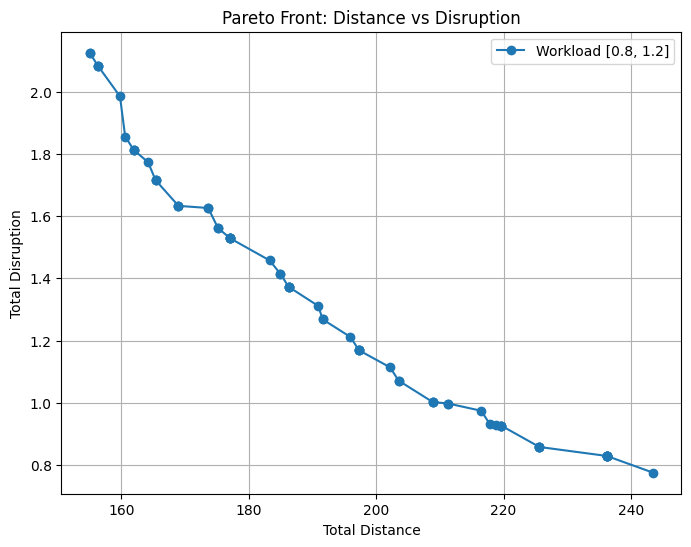

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 3750H with Radeon Vega Mobile Gfx, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 119 rows, 176 columns and 524 nonzeros
Model fingerprint: 0x2a4608f4
Variable types: 0 continuous, 176 integer (176 binary)
Coefficient statistics:
  Matrix range     [4e-02, 5e+01]
  Objective range  [4e-02, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 2e+02]
Found heuristic solution: objective 3.0955000
Presolve removed 88 rows and 88 columns
Presolve time: 0.00s
Presolved: 31 rows, 88 columns, 330 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 7.639048e-01, 32 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


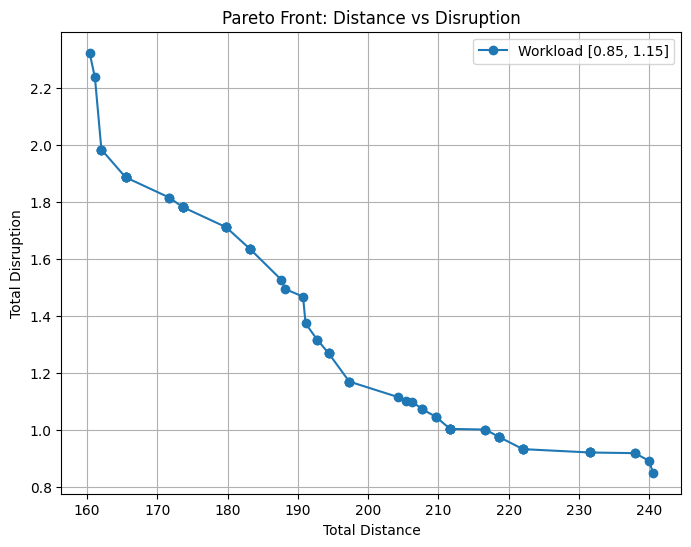

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 3750H with Radeon Vega Mobile Gfx, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 119 rows, 176 columns and 524 nonzeros
Model fingerprint: 0x558544cd
Variable types: 0 continuous, 176 integer (176 binary)
Coefficient statistics:
  Matrix range     [4e-02, 5e+01]
  Objective range  [4e-02, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-01, 2e+02]
Presolve removed 88 rows and 88 columns
Presolve time: 0.01s
Presolved: 31 rows, 88 columns, 330 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)
Found heuristic solution: objective 1.3286000

Root relaxation: objective 8.131265e-01, 29 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


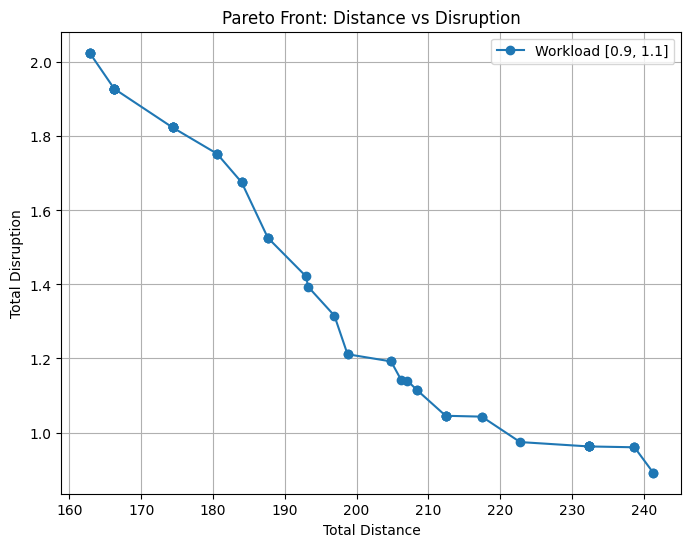

In [31]:
# Charger les données
bricks, reps, distances, index_values = load_data()
workload_bounds = [(0.8, 1.2), (0.85, 1.15), (0.9, 1.1)]

# Initial assignment (example)
initial_assignment = {
    1: 1, 2: 2, 3: 3, 4: 4, 5: 1, 6: 2, 7: 3, 8: 4, 9: 1, 10: 2, 11: 3, 12: 4,
    13: 1, 14: 2, 15: 3, 16: 4, 17: 1, 18: 2, 19: 3, 20: 4, 21: 1, 22: 2
}


for workload in workload_bounds:
    # Compute Pareto solutions
    max_distance = sum(distances[b][0] for b in bricks)  # Initial large distance
    pareto_solutions = epsilon_constraint_scheme(initial_assignment, max_distance, workload, bricks, reps, distances, index_values)

    # Filter non-dominated solutions
    non_dominated_solutions = filter_non_dominated_solutions(pareto_solutions)

    # Print the set of non-dominated solutions
    print("\nSet of Non-Dominated Solutions:")
    for L, U, distance, disruption in non_dominated_solutions:
        print(f"Workload [{L}, {U}] - Distance: {distance}, Disruption: {disruption}")

    # Plot the Pareto front
    plot_pareto_solutions(non_dominated_solutions)